In [16]:
import duckdb as db
import pandas as pd
import configs as cf
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
cf.mapeia_pastas()

In [4]:
import scripts as sc

In [5]:
con = db.connect("credito.db")

In [6]:
tabelas_sql = sc.create_database()

Esquemas e tabelas criados com sucesso!


In [7]:
#executando as tabelas no banco de dados
con.execute(tabelas_sql)

In [8]:
# Inserir dados nas tabelas
arquivos_sql = ["clientes", "emprestimos", "inadimplencia", "pagamentos"]

for arquivo in arquivos_sql:
    query = sc.ler_query(arquivo)
    con.execute(query)

In [9]:
# Testando a consulta
result = con.execute("""
    SELECT c.nome, i.total_em_atraso, i.dias_atraso, i.percentual_divida_sobre_renda
    FROM Clientes c
    JOIN Inadimplencia i ON c.id_cliente = i.id_cliente
""").fetchdf()

print(result)

               nome  total_em_atraso  dias_atraso  \
0        João Silva           5000.0           90   
1    Maria Oliveira           2000.0           15   
2      Carlos Souza           7000.0           45   
3       Ana Pereira           1000.0            5   
4        Lucas Lima           5000.0           60   
5    Juliana Santos           3000.0           30   
6    Fernando Costa           3000.0           25   
7      Paula Mendes           7000.0           90   
8      Roberto Lima           2000.0           10   
9       Carla Souza           5000.0           50   
10    Ricardo Alves           8000.0           75   
11  Vanessa Ribeiro           3500.0           35   

    percentual_divida_sobre_renda  
0                            0.25  
1                            0.40  
2                            0.28  
3                            0.12  
4                            0.23  
5                            0.20  
6                            0.18  
7                     

In [10]:
df_clientes = pd.read_sql("SELECT * FROM CLientes", con)
df_clientes

C:\Users\Gabriel\AppData\Local\Temp\ipykernel_8336\4112035254.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_clientes = pd.read_sql("SELECT * FROM CLientes", con)


,id_cliente,nome,idade,renda_mensal,score_credito,cidade
0,1,João Silva,30,4000.0,750,São Paulo
1,2,Maria Oliveira,28,5000.0,680,Rio de Janeiro
2,3,Carlos Souza,45,12000.0,750,Belo Horizonte
3,4,Ana Pereira,35,8000.0,720,São Paulo
4,5,Lucas Lima,55,15000.0,800,Curitiba
5,6,Juliana Santos,42,9000.0,670,Porto Alegre
6,7,Fernando Costa,50,7000.0,600,Brasília
7,8,Paula Mendes,33,3200.0,500,São Paulo
8,9,Roberto Lima,29,5500.0,720,Recife
9,10,Carla Souza,40,11000.0,800,Belo Horizonte


In [11]:
df_inadimplencia = pd.read_sql("SELECT * FROM Inadimplencia", con)
df_inadimplencia

C:\Users\Gabriel\AppData\Local\Temp\ipykernel_8336\3132226599.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_inadimplencia = pd.read_sql("SELECT * FROM Inadimplencia", con)


,id_cliente,total_em_atraso,dias_atraso,percentual_divida_sobre_renda
0,1,5000.0,90,0.25
1,2,2000.0,15,0.40
2,3,7000.0,45,0.28
3,4,1000.0,5,0.12
4,5,5000.0,60,0.23
5,6,3000.0,30,0.20
6,7,3000.0,25,0.18
7,8,7000.0,90,0.45
8,9,2000.0,10,0.12
9,10,5000.0,50,0.22


In [12]:
#Clientes com maior risco de inadimplência
risco_inadimplencia = pd.read_sql("""
    SELECT c.id_cliente, c.nome, e.valor_emprestado, i.dias_atraso, i.percentual_divida_sobre_renda
    FROM Clientes c
    JOIN Inadimplencia i ON c.id_cliente = i.id_cliente
    JOIN Emprestimos e ON c.id_cliente = e.id_cliente
    WHERE i.dias_atraso > 60
    ORDER BY i.percentual_divida_sobre_renda DESC;
""", con)

risco_inadimplencia

C:\Users\Gabriel\AppData\Local\Temp\ipykernel_8336\3640345404.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  risco_inadimplencia = pd.read_sql("""


,id_cliente,nome,valor_emprestado,dias_atraso,percentual_divida_sobre_renda
0,8,Paula Mendes,5000.0,90,0.45
1,11,Ricardo Alves,20000.0,75,0.40
2,1,João Silva,20000.0,90,0.25


In [13]:
#Média de taxa de juros por faixa de score de crédito
score_credito = pd.read_sql("""   
    SELECT 
        CASE 
            WHEN score_credito < 400 THEN 'Baixo'
            WHEN score_credito BETWEEN 400 AND 700 THEN 'Médio'
            ELSE 'Alto'
        END AS faixa_score,
        AVG(taxa_juros) AS media_juros
    FROM Clientes c
    JOIN Emprestimos e ON c.id_cliente = e.id_cliente
    GROUP BY faixa_score;
    """, con)

score_credito

C:\Users\Gabriel\AppData\Local\Temp\ipykernel_8336\2399068041.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  score_credito = pd.read_sql("""


,faixa_score,media_juros
0,Médio,7.233333
1,Alto,6.200000


In [ ]:
#Quantidade de inadimplêntes por cidade
inadimplencia_cidade = pd.read_sql(""" 
    SELECT c.cidade, 
       COUNT(DISTINCT i.id_cliente) AS inadimplentes
        FROM Clientes c
    LEFT JOIN Inadimplencia i ON c.id_cliente = i.id_cliente
    GROUP BY c.cidade
    ORDER BY inadimplentes DESC;
""", con)

inadimplencia_cidade

C:\Users\Gabriel\AppData\Local\Temp\ipykernel_8336\2650775273.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  inadimplencia_cidade = pd.read_sql("""


,cidade,inadimplentes
0,São Paulo,3
1,Porto Alegre,2
2,Belo Horizonte,2
3,Curitiba,2
4,Brasília,1
5,Recife,1
6,Rio de Janeiro,1


In [15]:
faixa_valor = pd.read_sql("""
    SELECT 
        CASE 
            WHEN total_em_atraso BETWEEN 2000 AND 3999.99 THEN 'Entre 2000 e 4000'
            WHEN total_em_atraso BETWEEN 4000 AND 7999.99 THEN 'Entre 4000 e 8000'
            WHEN total_em_atraso >= 8000 THEN 'Acima de 8000'
            ELSE 'Abaixo de 2000'
        END AS Faixa_Devedor,
        COUNT(*) AS Quantidade,
        COUNT(*) * 100.0 / (SELECT COUNT(*) FROM inadimplencia) AS Percentual
    FROM inadimplencia
    GROUP BY Faixa_Devedor;
""", con)

faixa_valor

C:\Users\Gabriel\AppData\Local\Temp\ipykernel_8336\410398790.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  faixa_valor = pd.read_sql("""


,Faixa_Devedor,Quantidade,Percentual
0,Entre 2000 e 4000,5,41.666667
1,Entre 4000 e 8000,5,41.666667
2,Abaixo de 2000,1,8.333333
3,Acima de 8000,1,8.333333


C:\Users\Gabriel\AppData\Local\Temp\ipykernel_8336\514017481.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


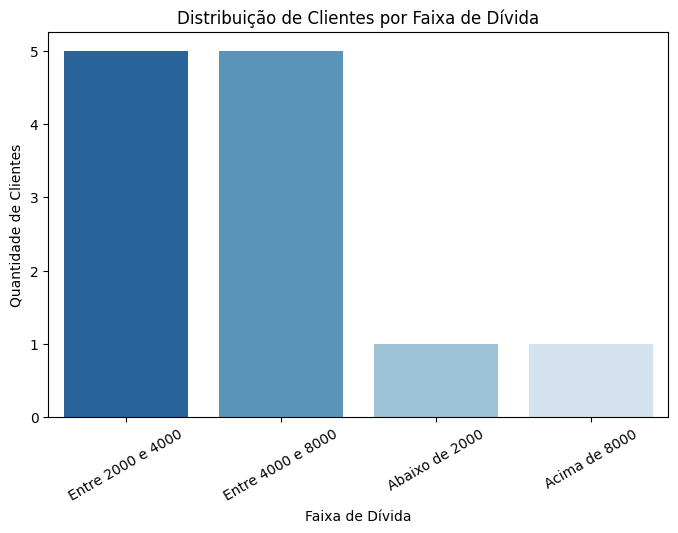

In [17]:
plt.figure(figsize=(8, 5))
sns.barplot(
    x=faixa_valor['Faixa_Devedor'], 
    y=faixa_valor['Quantidade'], 
    palette="Blues_r"
)

plt.xlabel("Faixa de Dívida")
plt.ylabel("Quantidade de Clientes")
plt.title("Distribuição de Clientes por Faixa de Dívida")

plt.xticks(rotation=30)

plt.show()